#**Attention-Resnet**

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from dataloader import *
from atten_resnet import atten_resnet
from train import *

we prepared a sharelink from google dive:

https://drive.google.com/drive/folders/1aw7nqrXkBRZp94Ef04s3xeH-2gQRPb97?usp=sharing

Add a shortcut to your own google drive and mount drive on google colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##load data & model

In [3]:
#DIRECTORIES
path_metadata = "/content/drive/MyDrive/dataset/metadata.csv" ## directory of dataframe of image directories and classes
path_pneumonia = "/content/drive/MyDrive/dataset/Dataset/pneumonia" ## directory of images of pneumonia classes
directory_dataset='/content/drive/MyDrive/dataset/Dataset' ## directory of all classes folders

image_size=(224, 224)
batch_size = 32

## call a function to load datasets
train_dataset,validation_dataset,test_dataset, y_true,y_true_oh,train_steps,validation_steps,test_steps,_,_,_ = data_func(
    batch_size ,
    path_metadata ,
    path_pneumonia ,
    directory_dataset,
    image_size )

Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 validated image filenames belonging to 3 classes.
Found 50 validated image filenames belonging to 3 classes.


In [4]:
input_shape = 224, 224, 3 # size and channel of images
n_classes = 3 # number of classes

# call the model
model = atten_resnet(input_shape,n_classes)

##train

In [5]:
checkpoint_filepath =  '/content/atten'
opt = SGD(
    learning_rate=0.0001,
    momentum=0.9,
    nesterov=True,
    weight_decay=0.0001)

from time import time
start = time()

with tf.device('/gpu:0'):
  history_atten,model3 = train(train_dataset, model,'attenresnet',
           train_steps,
           validation_dataset,
           validation_steps,
           checkpoint_filepath,
           epoch=150,
           opt = opt)

print('Total run time = {:.2f} min '.format((time()-start)/60))

Epoch 1/150
91/91 [==============================] - 1973s 21s/step - loss: 0.9885 - accuracy: 0.5325 - val_loss: 1.1417 - val_accuracy: 0.3395 - lr: 1.0000e-04
Epoch 2/150
91/91 [==============================] - 84s 925ms/step - loss: 0.8048 - accuracy: 0.6523 - val_loss: 1.2926 - val_accuracy: 0.3764 - lr: 1.0000e-04
Epoch 3/150
91/91 [==============================] - 84s 921ms/step - loss: 0.7272 - accuracy: 0.6844 - val_loss: 1.5100 - val_accuracy: 0.3480 - lr: 1.0000e-04
Epoch 4/150
91/91 [==============================] - 85s 928ms/step - loss: 0.7045 - accuracy: 0.7068 - val_loss: 0.7211 - val_accuracy: 0.7131 - lr: 1.0000e-04
Epoch 5/150
91/91 [==============================] - 84s 919ms/step - loss: 0.6495 - accuracy: 0.7338 - val_loss: 0.8730 - val_accuracy: 0.6392 - lr: 1.0000e-04
Epoch 6/150
91/91 [==============================] - 84s 920ms/step - loss: 0.6447 - accuracy: 0.7462 - val_loss: 1.4139 - val_accuracy: 0.4616 - lr: 1.0000e-04
Epoch 7/150
91/91 [===============

### model summary

In [6]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  4736        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 32)   0           ['conv2d[0][0]']                 
                                                                                              

## test evaluation

In [7]:
# evaluation with last epoch weights
loss, accuracy = model3.evaluate(test_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy*100)

915/915 [==============================] - 476s 519ms/step - loss: 0.3832 - accuracy: 0.8710
Loss:  0.3832389712333679
Accuracy:  87.10382580757141


In [8]:
# loading the weights with the best accuracy of validation dataset
model3.load_weights(checkpoint_filepath)

In [9]:
loss, accuracy = model3.evaluate(test_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

915/915 [==============================] - 18s 20ms/step - loss: 0.3498 - accuracy: 0.8929
Loss:  0.34978991746902466
Accuracy:  0.8928961753845215


In [10]:
with tf.device('/gpu:0'):
  test_values = model3.predict(test_dataset, steps=test_steps)

915/915 [==============================] - 19s 19ms/step


In [11]:
#save the prediction of the model on the test dataset to use in ensemble model
np.save("test_p_atten", test_values)

### precision, recall, fscore

In [12]:
# preparing test result

test_value_max = np.argmax(test_values,axis=1)
test_value_max_oh = convert_to_one_hot(test_value_max,3).T

In [13]:
accuracy = accuracy_score(y_true_oh, test_value_max_oh)

print('Accuracy = {:.2f}%'.format(accuracy*100))
print(classification_report(y_true_oh, test_value_max_oh,target_names=['Normal','Covid','Pneumonia']))

Accuracy = 89.29%
              precision    recall  f1-score   support

      Normal       0.79      0.92      0.85       280
       Covid       0.92      0.89      0.91       320
   Pneumonia       0.99      0.87      0.92       315

   micro avg       0.89      0.89      0.89       915
   macro avg       0.90      0.89      0.89       915
weighted avg       0.90      0.89      0.89       915
 samples avg       0.89      0.89      0.89       915



###confusion matrix



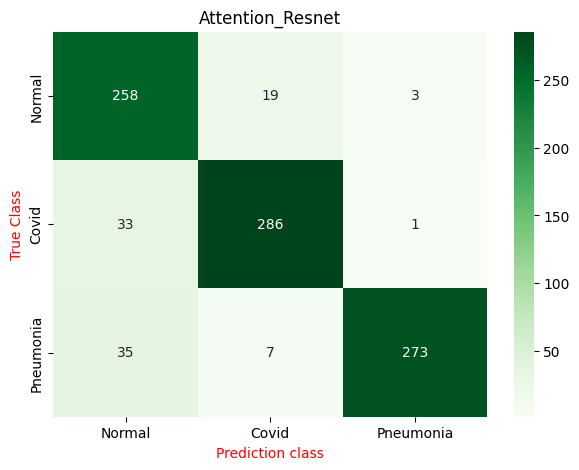

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(y_true,test_value_max)

plt.figure(figsize = (7,5))
plt.title('Attention_Resnet')
x_axis_labels = ['Normal','Covid','Pneumonia']
sns.heatmap(cf_matrix, annot=True,  fmt='g', cmap="Greens", xticklabels=x_axis_labels, yticklabels=x_axis_labels)
plt.xlabel('Prediction class', color = 'r')
plt.ylabel(ylabel='True Class', color="r")
plt.savefig('h_atten.png')